In [1]:
import seaborn as sns
sns.set()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Read raw file

In [2]:
path = 'data/Reading_raw.xlsx'
def preprocessing(path):
    df = pd.read_excel(path, converters={'date': pd.to_datetime}).drop(['Unnamed: 8'], axis=1)
    
    # Drop row where waiting for new book to arrive
    df = df[df['book'].ne('Deep Learning')]
    return df

Create dataframes for analysis

In [3]:
df = preprocessing(path)

booking_logic = df['book'].ne('Fail')
book_df = df[booking_logic]
fail_df = df[~booking_logic]

How many books read and what were they

In [4]:
total = df['book'].nunique()
books = df['book'].unique().tolist()
print(total)
print(books)

8
['How Not to Be Wrong The Power of Mathematical Thinking', 'How I Killed Pluto and Why It Had It Coming', 'Fail', 'The Physics of God', 'A Gentleman in Moscow', 'Algorithms to Live By', 'Batman and Ethics', 'Where Do I Begin']


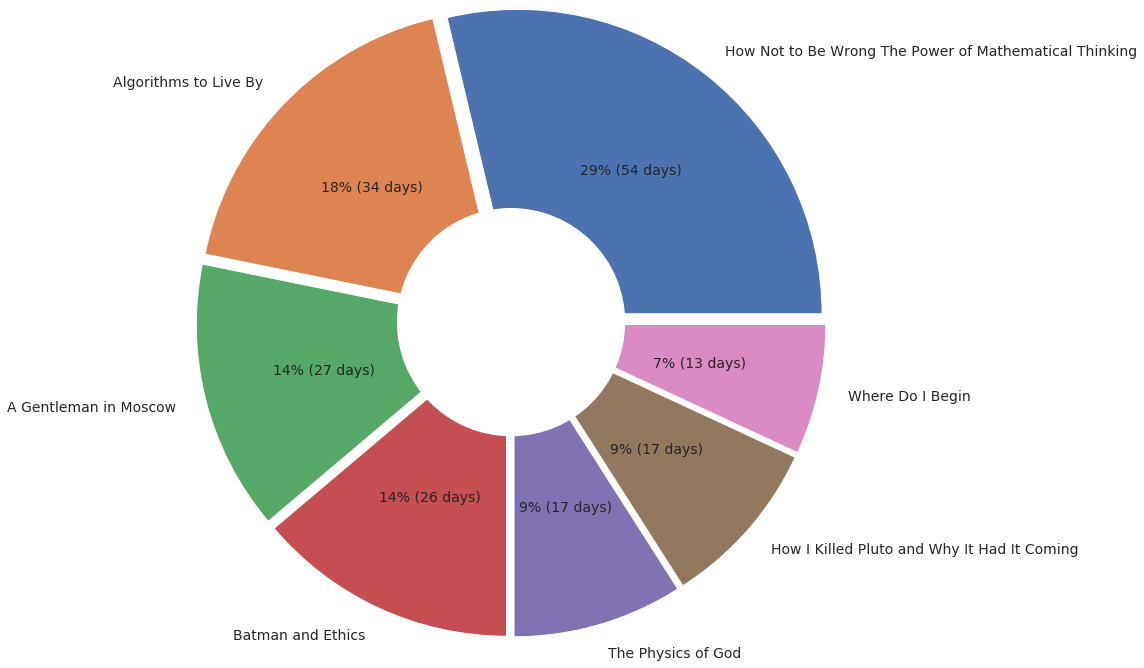

In [5]:
explode = [0.07] * 7
ax = book_df['book'].value_counts().plot.pie(autopct=lambda x: '{:.0f}% ({:.0f} days)'.format(x, x * 188/100), radius=2, fontsize=14, figsize=(7, 7), explode=explode)


centre_circle = plt.Circle((0,0),0.75,color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

How many pages was each book

In [6]:
book_df.drop_duplicates(['book'], keep='last')[['book', 'end_pg']]

,book,end_pg
21,How I Killed Pluto and Why It Had It Coming,262
46,The Physics of God,182
147,How Not to Be Wrong The Power of Mathematical ...,441
181,A Gentleman in Moscow,462
280,Algorithms to Live By,262
323,Where Do I Begin,275
358,Batman and Ethics,238


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


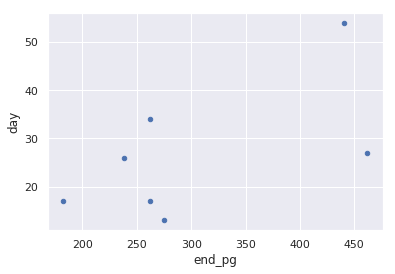

In [7]:
pie_df = book_df.drop_duplicates(['book'], keep='last')[['book', 'end_pg']].set_index('book').merge(book_df['book'].value_counts().to_frame(), left_index=True, right_index=True).rename(columns={'book': 'day'})
pie_df.plot(kind='scatter', x='end_pg', y='day')

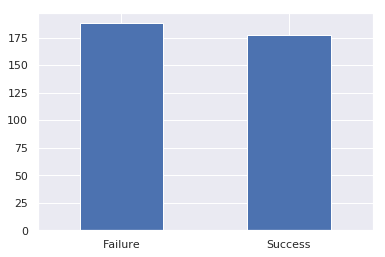

In [8]:
df.assign(success=lambda x: x['book'].eq('Fail'))['success'].astype(int).map({0: 'Failure', 1: 'Success'}).value_counts().plot(kind='bar', rot=0)

In [9]:
count = fail_df['comment'].str.lower().nunique()
print('{} reasons for not reading'.format(count))

70 reasons for not reading


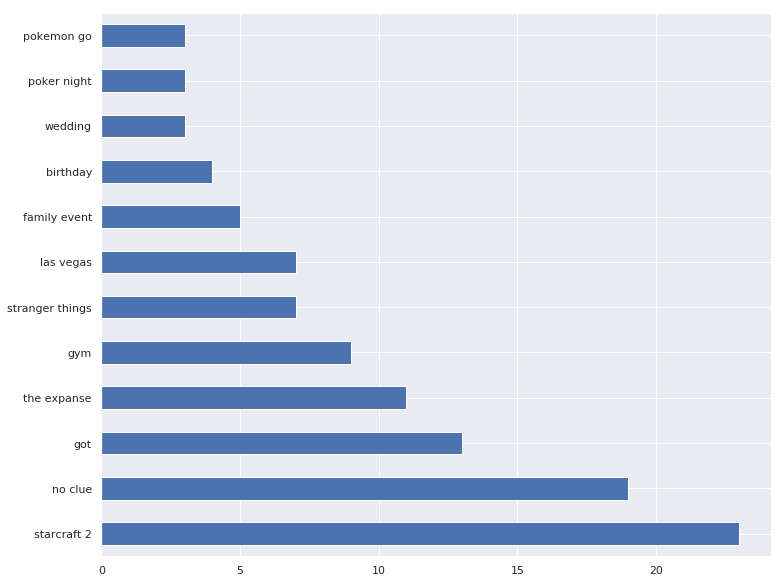

In [10]:
fail_df['comment'].str.lower().value_counts().nlargest(12).plot.barh(figsize=(12, 10))

In [11]:
# Most pages read in one day
df['pages_read'] = df['end_pg'] - df['start_pg']
df.loc[df['pages_read'].idxmax()]

# Amazing how the day i read the most I had no comments

date          2019-11-08 00:00:00
book             Where Do I Begin
author                Elvis Duran
time_start               23:01:00
time_end                 23:48:00
start_pg                      100
end_pg                        145
comment                       NaN
pages_read                     45
Name: 312, dtype: object

In [12]:
# longest reading day
te = pd.to_datetime(book_df['time_end'].astype(str), format='%H:%M:%S')
ts = pd.to_datetime(book_df['time_start'].astype(str), format='%H:%M:%S')
book_df['time_reading'] = ((te - ts).dt.seconds / 60).astype(int)

/home/ksooklall/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [13]:
bmean, bstd = book_df['time_reading'].mean(), book_df['time_reading'].std()

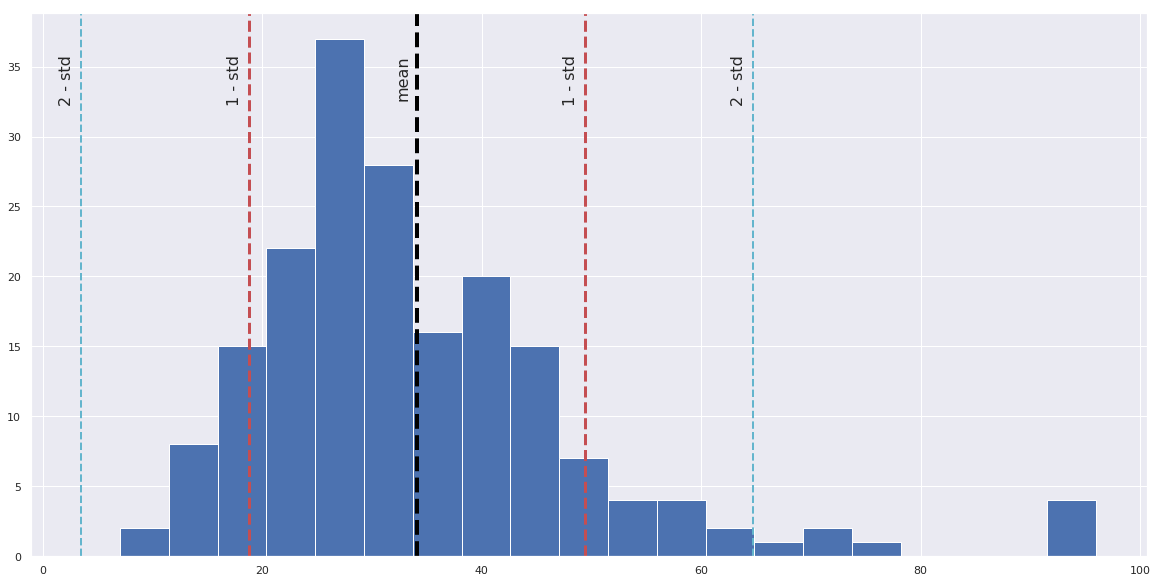

In [14]:
pad = 2
fontsize=16

plt.axvline(bmean, color='black', linestyle='dashed', linewidth=4)
plt.axvline(bmean + bstd, color='r', linestyle='dashed', linewidth=3)
plt.axvline(bmean - bstd, color='r', linestyle='dashed', linewidth=3)
plt.axvline(bmean + 2 * bstd, color='c', linestyle='dashed', linewidth=2)
plt.axvline(bmean - 2 * bstd, color='c', linestyle='dashed', linewidth=2)

plt.text(bmean-pad, 35,'mean',fontsize=fontsize,rotation=90)
plt.text(bmean+bstd-pad,35,'1 - std',fontsize=fontsize,rotation=90)
plt.text(bmean-bstd-pad, 35, '1 - std',fontsize=fontsize,rotation=90)
plt.text(bmean+2*bstd-pad, 35, '2 - std',fontsize=fontsize,rotation=90)
plt.text(bmean-2*bstd-pad, 35, '2 - std',fontsize=fontsize,rotation=90)

book_df['time_reading'].hist(figsize=(20, 10), bins=20)

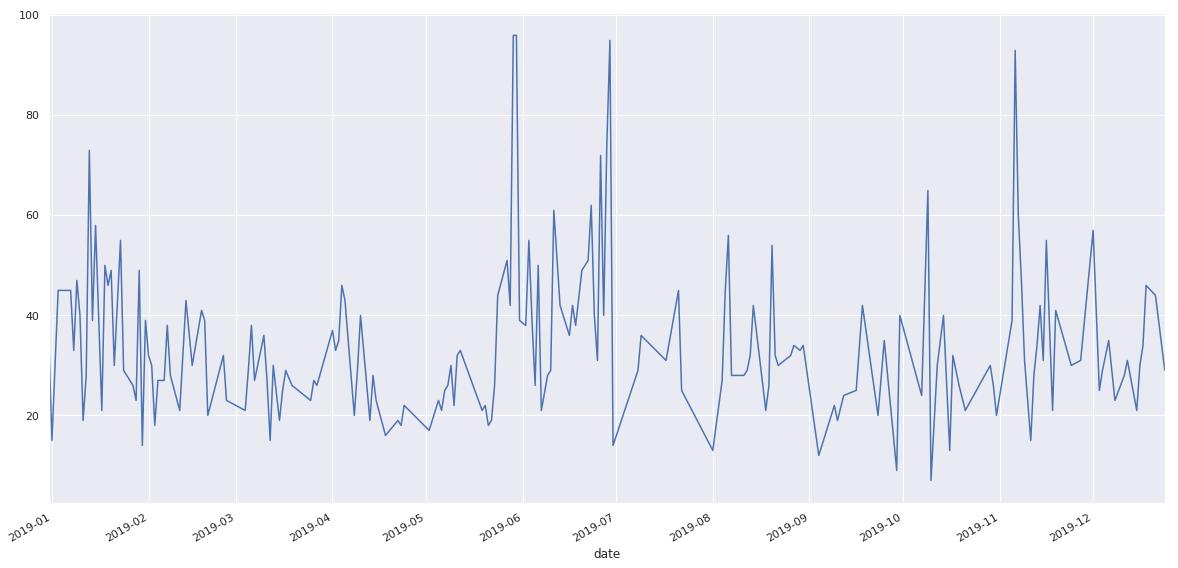

In [15]:
book_df.set_index('date')['time_reading'].plot(figsize=(20, 10))

In [16]:
# a little more than an hour and a half
book_df.loc[book_df['time_reading'].idxmax()]

date              2019-05-29 00:00:00
book            A Gentleman in Moscow
author                    Amor Towles
time_start                   22:50:00
time_end                     00:26:00
start_pg                           18
end_pg                             48
comment                    Baudelaire
time_reading                       96
Name: 149, dtype: object

In [17]:
df = df.merge(book_df['time_reading'], left_index=True, right_index=True, how='outer')

In [18]:
tmp = df['time_start'].where(df['time_start'].eq(0), 1).astype(int)
tmp = tmp.groupby(tmp.eq(0).cumsum()).cumsum()

end = tmp.idxmax()
length = tmp.max()

In [19]:
longest_streak = df.loc[end - length + 1:end]
longest_streak

,date,book,author,time_start,time_end,start_pg,end_pg,comment,pages_read,time_reading
6,2019-01-06,How I Killed Pluto and Why It Had It Coming,Mike Brown,23:00:00,23:45:00,20,28,NaN,8,45.0
7,2019-01-07,How I Killed Pluto and Why It Had It Coming,Mike Brown,23:00:00,23:45:00,28,42,NaN,14,45.0
8,2019-01-08,How I Killed Pluto and Why It Had It Coming,Mike Brown,22:40:00,23:13:00,42,47,NaN,5,33.0
9,2019-01-09,How I Killed Pluto and Why It Had It Coming,Mike Brown,22:10:00,22:57:00,47,72,NaN,25,47.0
10,2019-01-10,How I Killed Pluto and Why It Had It Coming,Mike Brown,22:40:00,23:20:00,72,86,NaN,14,40.0
11,2019-01-11,How I Killed Pluto and Why It Had It Coming,Mike Brown,23:34:00,23:53:00,86,94,NaN,8,19.0
12,2019-01-12,How I Killed Pluto and Why It Had It Coming,Mike Brown,14:57:00,15:25:00,94,102,NaN,8,28.0
13,2019-01-13,How I Killed Pluto and Why It Had It Coming,Mike Brown,23:12:00,00:25:00,102,130,NaN,28,73.0
14,2019-01-14,How I Killed Pluto and Why It Had It Coming,Mike Brown,22:25:00,23:04:00,130,140,NaN,10,39.0
15,2019-01-15,How I Killed Pluto and Why It Had It Coming,Mike Brown,22:44:00,23:42:00,140,166,NaN,26,58.0


In [20]:
print(longest_streak['time_reading'].sum() % 60)
longest_streak['pages_read'].sum()

7.0


146

In [21]:
lstart = longest_streak.iloc[0]['date']
lend = longest_streak.iloc[-1]['date']

In [22]:
df.groupby(df['pages_read'].ne(0).cumsum()).cumsum().head(10)

,start_pg,end_pg,pages_read,time_reading
0,233,240,7,35.0
1,240,248,8,15.0
2,248,252,4,30.0
3,1,14,13,45.0
4,14,20,6,45.0
5,14,20,6,NaN
6,20,28,8,45.0
7,28,42,14,45.0
8,42,47,5,33.0
9,47,72,25,47.0


In [23]:
tmp.head(10)

0    1
1    2
2    3
3    4
4    5
5    0
6    1
7    2
8    3
9    4
Name: time_start, dtype: int64

In [30]:
from matplotlib.collections import LineCollection

Change color of line based on book https://stackoverflow.com/questions/44642966/how-to-plot-multi-color-line-if-x-axis-is-date-time-index-of-pandas

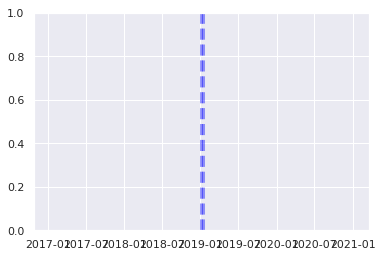

In [48]:
plt.axvline(lstart, color='blue', linestyle='dashed', linewidth=3, alpha=0.4)
plt.axvline(lend, color='blue', linestyle='dashed', linewidth=3, alpha=0.4)

colors = ['yellowgreen','cyan','magenta', 'red','blue','green', 'yellow', 'black']
colors = {v: k for k, v in zip(colors, df['book'].unique())}
#df.set_index('date')['time_reading'].fillna(0).plot(figsize=(20, 12), colors=colors)

In [49]:
colors

{'How Not to Be Wrong The Power of Mathematical Thinking': 'yellowgreen',
 'How I Killed Pluto and Why It Had It Coming': 'cyan',
 'Fail': 'magenta',
 'The Physics of God': 'red',
 'A Gentleman in Moscow': 'blue',
 'Algorithms to Live By': 'green',
 'Batman and Ethics': 'yellow',
 'Where Do I Begin': 'black'}

In [61]:
df[df['book'] == 'How Not to Be Wrong The Power of Mathematical Thinking'].head()

,date,book,author,time_start,time_end,start_pg,end_pg,comment,pages_read,time_reading
0,2018-12-31,How Not to Be Wrong The Power of Mathematical ...,jordan ellenberg,15:45:00,16:20:00,233,240,Started,7,35.0
1,2019-01-01,How Not to Be Wrong The Power of Mathematical ...,jordan ellenberg,22:56:00,23:11:00,240,248,NaN,8,15.0
2,2019-01-02,How Not to Be Wrong The Power of Mathematical ...,jordan ellenberg,23:00:00,23:30:00,248,252,NaN,4,30.0
49,2019-02-18,How Not to Be Wrong The Power of Mathematical ...,Jordan Ellenberg,23:22:00,00:03:00,1,15,iron man,14,41.0
50,2019-02-19,How Not to Be Wrong The Power of Mathematical ...,Jordan Ellenberg,22:46:00,23:25:00,15,28,laffer curve,13,39.0


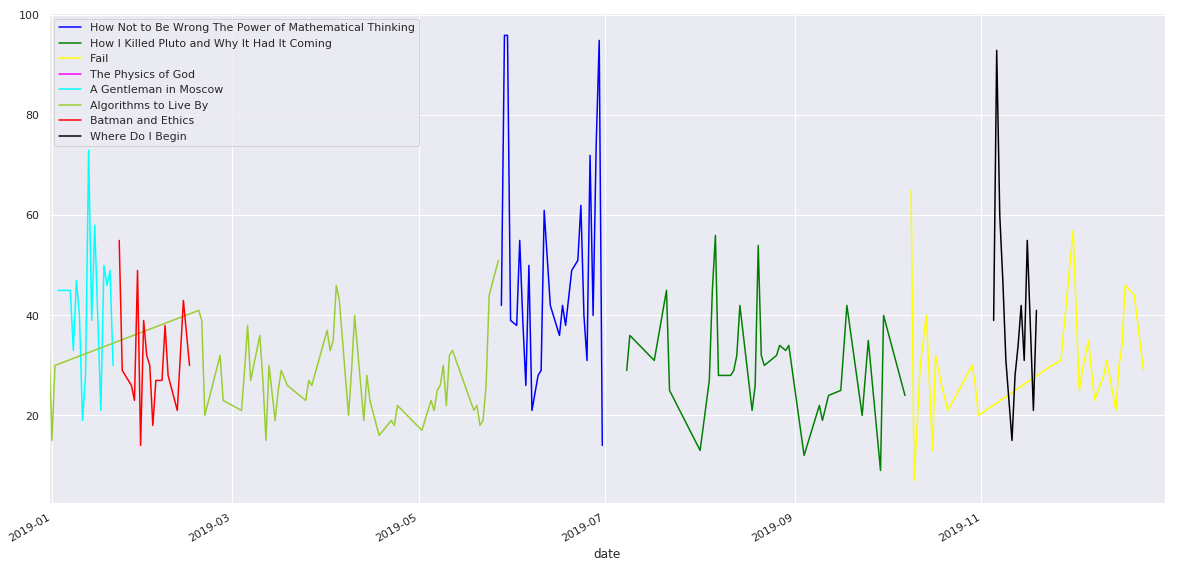

In [74]:
pdf = df[['date', 'book', 'time_reading']]
_, ax = plt.subplots(figsize=(20, 10))

for n, g in pdf.groupby('book'):
    #import pdb; pdb.set_trace()
    g.plot('date', 'time_reading' , ax=ax, color=colors[n])
    #g.legend(g['book'].iloc[0])
ax.legend(df['book'].unique())

In [37]:
df['book'].unique()

array(['How Not to Be Wrong The Power of Mathematical Thinking',
       'How I Killed Pluto and Why It Had It Coming', 'Fail',
       'The Physics of God', 'A Gentleman in Moscow',
       'Algorithms to Live By', 'Batman and Ethics', 'Where Do I Begin'],
      dtype=object)

The longest reading streak was at the start of the year and last 10 days in which time I read about 7hrs and 146 pages

In [25]:
df['time_reading'].max()

96.0

<Figure size 720x1080 with 0 Axes>

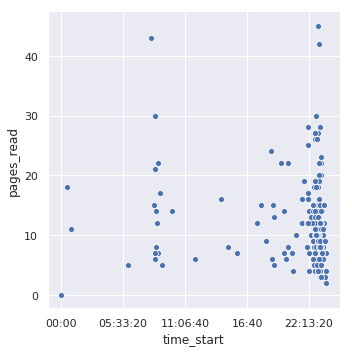

<Figure size 720x1080 with 0 Axes>

In [26]:
sns.relplot(x='time_start', y='pages_read', data=df)
plt.figure(figsize=(10, 15))

In [27]:
%matplotlib inline

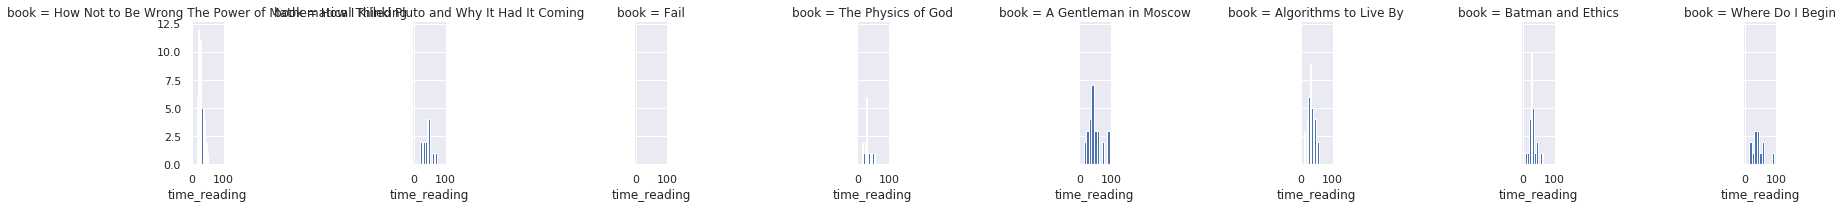

In [28]:
a = sns.FacetGrid(df, col='book')
a.map(plt.hist, 'time_reading')

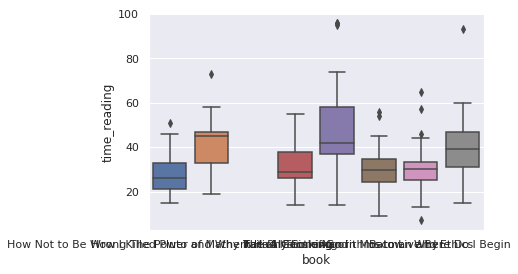

In [31]:
sns.boxplot(x='book', y='time_reading', data=df)

## Preferred time of day to read

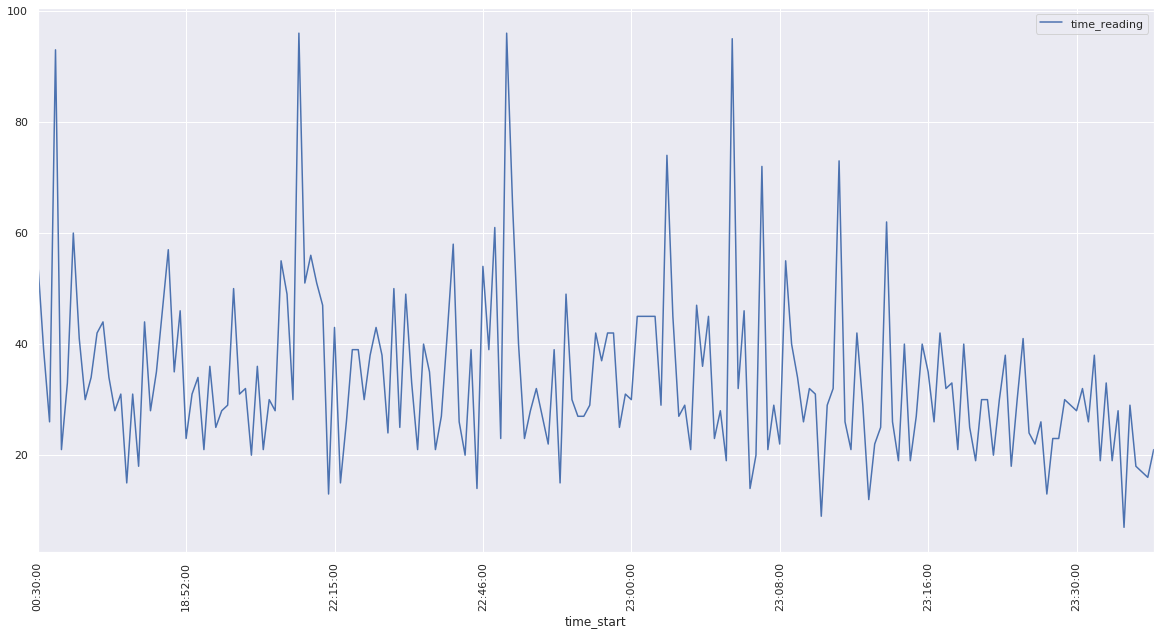

In [179]:
#plt.axvline(1, color='b', linestyle='yellow', linewidth=3)
book_df.sort_values('time_start', ascending=True).plot(x='time_start', y='time_reading', rot=90, figsize=(20, 10))

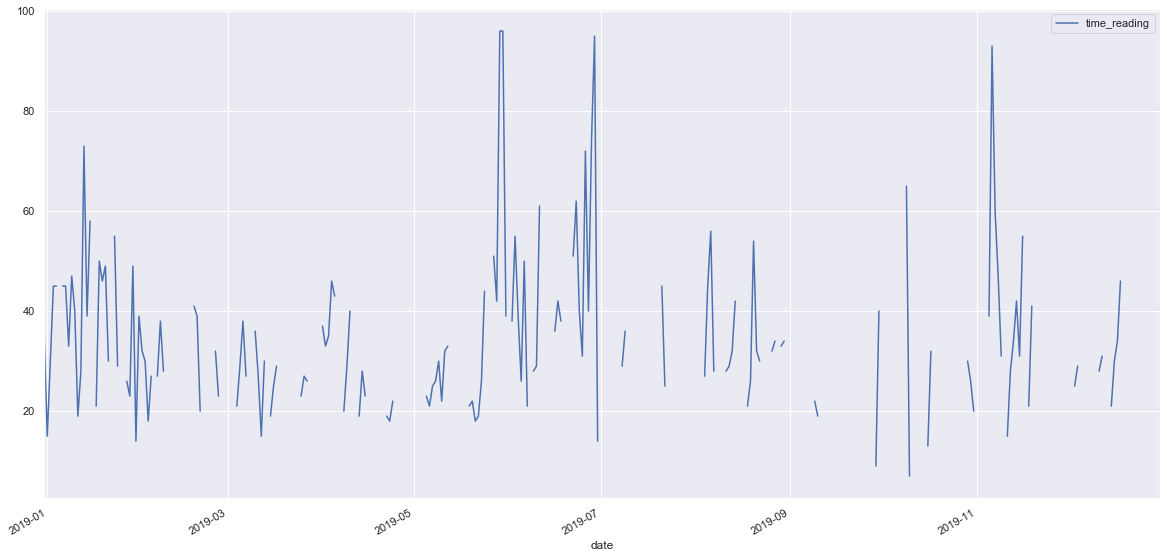

In [46]:
df.plot(x='date', y='time_reading', kind='line', figsize=(20, 10))